In [1]:
#external stuff
import h5py
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
import cv2
import numpy as np
import math
import mahotas
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, MeanShift, estimate_bandwidth, SpectralClustering
import traceback
from uuid import uuid4 as unique_identifier
import random
import os
from time import perf_counter
from glob import glob
import pandas as pd
from scipy.optimize import linear_sum_assignment

from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import timm

In [2]:
#internal stuff
from contour_impl import do_contour_create, do_contour_compare
from imageprocessing import maybetogray,maybetocolor, image_preprocess, canny, recenter, prep_img
from aberrations import aberrations

In [3]:
# some more stuff
from math import cos, sin
from PIL import Image, ImageDraw

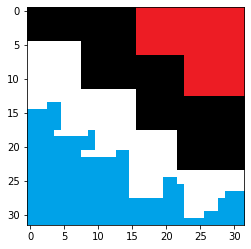

In [12]:
# load some test images
img_files=["stairtest.png","stairtest2.png","cornertest.png","cornertest2.png","cornertest3.png","cornertest4.png","tdl.png","tdl2.png","tokyo.png","tokyo2.png"]
test_images=[cv2.cvtColor(cv2.imread(iname), cv2.COLOR_BGR2RGB) for iname in img_files]
timg = test_images[0]
plt.imshow(timg)

In [25]:
def image5dfeats(img,w1=1.0,w2=1.0):
    coords = []
    vals = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            coords.append([i,j,1.0])
            vals.append([*img[i,j],1.0])
    coords2 = coords/(np.linalg.norm(coords,axis=1, keepdims=True)/w1)
    vals2 = vals/(np.linalg.norm(vals,axis=1,keepdims=True)/w2)
    return np.concatenate([coords2,vals2],axis=1), np.array(coords)[:,:-1], np.array(vals)[:,:-1]
feats,_,vals=image5dfeats(timg)

In [28]:
clustering=AgglomerativeClustering(n_clusters=4)
clustering.fit(feats)

AgglomerativeClustering(n_clusters=4)

In [30]:
np.unique(clustering.labels_)

array([0, 1, 2, 3], dtype=int64)

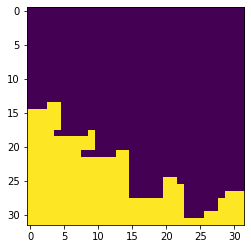

In [35]:
plt.imshow((clustering.labels_==0).reshape(32,32))

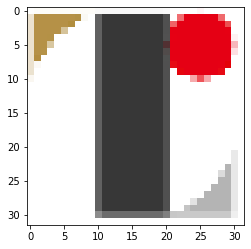

In [40]:
timg2=test_images[-3]
plt.imshow(timg2)

In [105]:
feats,_,vals=image5dfeats(timg2,0.5,5)
connectivity=grid_to_graph(*timg2.shape[:2])
clustering=AgglomerativeClustering(n_clusters=5,connectivity=connectivity)
clustering.fit(feats)

AgglomerativeClustering(connectivity=<1024x1024 sparse matrix of type '<class 'numpy.int32'>'
	with 4992 stored elements in COOrdinate format>,
                        n_clusters=5)

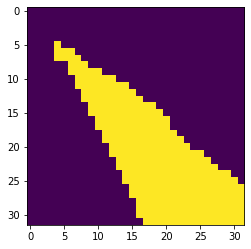

In [111]:
plt.imshow((clustering.labels_==4).reshape(32,32))

In [112]:
feats = timg2.reshape(-1,3)
connectivity=grid_to_graph(*timg2.shape[:2])
clustering=AgglomerativeClustering(n_clusters=5,connectivity=connectivity)
clustering.fit(feats)

AgglomerativeClustering(connectivity=<1024x1024 sparse matrix of type '<class 'numpy.int32'>'
	with 4992 stored elements in COOrdinate format>,
                        n_clusters=5)

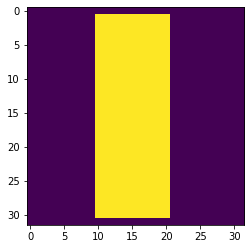

In [118]:
plt.imshow((clustering.labels_==0).reshape(32,32))

In [132]:
# image manipulation
# for all the different methods we first make a copy of the image just in case
# something decides to modify the original.
# Thank God for gigabytes of RAM
def stack(funcs):
    #compose several image manipulations 
    def nf(img):
        img=img[:]
        for f in funcs:
            img=f(img)
        return img
    return nf
def noop(img):
    return img
def color_reduce_kmeans(img, n_colors=8):
    img=img[:]
    h,w,c=img.shape
    fimg=np.clip(img.reshape(-1,3)/255,0.05,0.95)
    km=KMeans(n_clusters=n_colors,random_state=0).fit(fimg)
    means=np.clip(km.cluster_centers_,0.0,1.0)
    labels=km.predict(fimg)
    return (means[labels].reshape(img.shape)*255).astype(np.uint8)

def smooth_median(img,ks=5,n=2):
    img=img[:]
    for i in range(n):
        img=cv2.medianBlur(img,ks)
    return img
def std_size(img):
    img=img[:]
    return cv2.resize(img,(128,128),interpolation=cv2.INTER_AREA)

def big_size(img):
    return cv2.resize(img,None, fx=13, fy=13, interpolation=cv2.INTER_AREA)

# segmentation
def scast2(x,r):
        xpad=np.pad(x,[[0,0],[0,1]],mode="constant", constant_values=r)
        return xpad/np.linalg.norm(x,axis=1,keepdims=True)
def genkeys(n,d):
    r=np.random.normal(size=(n,d))
    r=r/np.linalg.norm(r,axis=1,keepdims=True)
    r=np.pad(r,[[1,0],[0,1]],mode="constant",constant_values=0)
    r[0,-1]=1
    return r
def meancolor(img,b):
    return np.floor(np.sum(img[b],(0)) / (0.01+np.sum(b))).astype(np.uint8)
def clamp(x, m,M):
    if x < m:
        return m
    if x > M:
        return M
    return x
def gsb(s,margin=10):
    h,w=s.shape
    x,y=np.where(s)
    x1=clamp(x.min()-margin,0,w)
    y1=clamp(y.min()-margin,0,h)
    x2=clamp(x.max()+margin,0,w)
    y2=clamp(y.max()+margin,0,h)
    return x1,y1,x2,y2
    #return x.min()-margin, y.min()-margin, x.max()+margin, y.max()+margin
def cropresize(img,b,bg=None,**kwargs):
    try:
        x1,y1,x2,y2=gsb(b)
        if bg is not None:
            img=img.copy()
            img[b!=True]=bg
        diff = max(x2-x1, y2-y1)
        xc = (x2+x1)/2
        yc = (y2+y1)/2
        return cv2.resize(img[x1:x2,y1:y2,:],img.shape[:-1])
    except:
        log(kwargs,{'type':'Error', 'method':'Segmentation', 'fn':'cropresize'})
        return None
def segment_labels(img,labels,bg=None,rejection=0.0,**kwargs):
    ulabels=np.unique(labels)
    h,w=labels.shape
    total=h*w
    masks=[labels==i for i in ulabels]
    # throw away any masks that cover less than 'rejection' percent of the image
    masks=[m for m in masks if np.sum(m) >= (rejection*total)]
    segs= [cropresize(img,b,bg,**kwargs) for b in masks]
    return [s for s in segs if s is not None]
def plot_many(imgs,n_c=3):
    # convenience function to plot many images
    n_r = (len(imgs)//n_c)+1
    cc=1
    fig=plt.figure(figsize=(10,10))
    for i in imgs:
        fig.add_subplot(n_r,n_c,cc)
        plt.imshow(i)
        cc+=1
def segment_agglomerative(img,n_clusters=5,**kwargs):
    feats = img.reshape(-1,3)
    connectivity=grid_to_graph(*img.shape[:2])
    clustering=AgglomerativeClustering(n_clusters=n_clusters,connectivity=connectivity)
    clustering.fit(feats)
    return segment_labels(img,clustering.labels_.reshape(img.shape[:2]),**kwargs)

In [141]:
segimgs=segment_agglomerative(timg2,bg=[255,255,255])

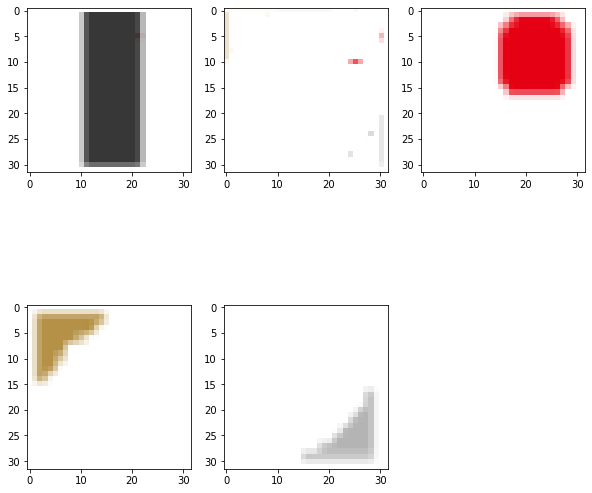

In [142]:
segimgs=segment_agglomerative(timg2,bg=[255,255,255])
plot_many(segimgs)

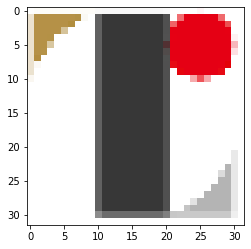

In [143]:
plt.imshow(timg2)

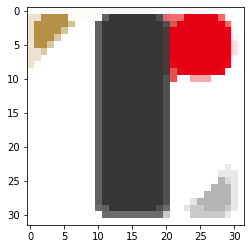

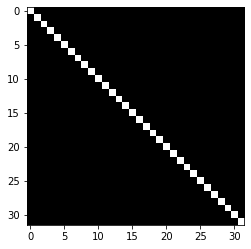

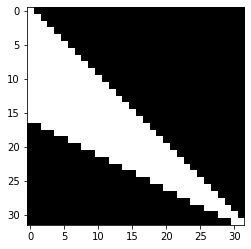

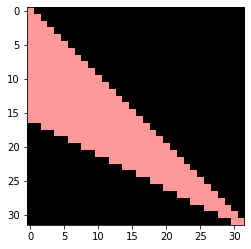

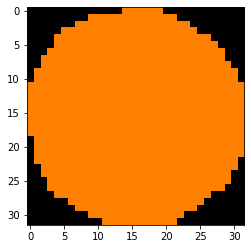

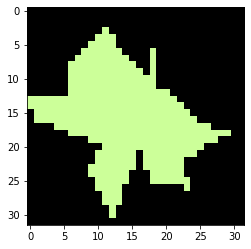

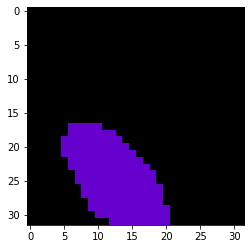

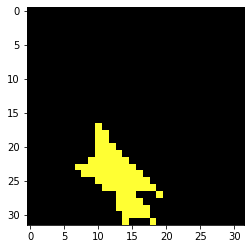

In [5]:
def draw_poly(dc,poly, scale=1, **kwargs):
    coords = (poly*scale).astype(int)
    dc.polygon([tuple(i) for i in coords],**kwargs)
polys=[# wedge
       [[0,0], [0,0.5], [1,1]],
       # circle
       [[0.5+cos(x*6.14/20)/2,0.5+sin(x*6.14/20)/2] for x in range(20)],
       # randomly perturbed circle
       [[0.5+cos(x*6.14/20)*np.random.uniform(0.2,1.0)/2,0.5+sin(x*6.14/20)*np.random.uniform(0.2,1.0)/2] for x in range(20)],
       # squished circle
       [[0.43889485, 1.01199527],
           [0.50584096, 1.03654858],
           [0.56339267, 1.03823472],
           [0.60616826, 1.01689601],
           [0.63016773, 0.97452786],
           [0.63314687, 0.91509216],
           [0.61482709, 0.8441468 ],
           [0.5769215 , 0.76832597],
           [0.52297469, 0.69471975],
           [0.45803129, 0.63021113],
           [0.38816421, 0.58083239],
           [0.31990682, 0.551201  ],
           [0.25964192, 0.5440878 ],
           [0.21300497, 0.56015797],
           [0.18435702, 0.59790877],
           [0.17637698, 0.65381007],
           [0.18981107, 0.72263449],
           [0.22340306, 0.79794618],
           [0.27401172, 0.87270266],
           [0.33690458, 0.93991338]],
      # star thing
      [[0.41807544, 0.87534801],
       [0.46415562, 0.98536887],
       [0.53947724, 0.94539019],
       [0.59524502, 1.0083861 ],
       [0.51879522, 0.89930979],
       [0.48691866, 0.83740086],
       [0.6054967 , 0.86355202],
       [0.58552607, 0.83129026],
       [0.41381491, 0.66344889],
       [0.4658818 , 0.68867009],
       [0.38576388, 0.62978679],
       [0.32330981, 0.55634607],
       [0.32094132, 0.70405591],
       [0.32852805, 0.70085152],
       [0.3041241 , 0.72073516],
       [0.28525641, 0.71508238],
       [0.22339421, 0.71973661],
       [0.35555229, 0.82499804],
       [0.33906122, 0.81146125],
       [0.38112243, 0.83347015]]]
polys=[np.array(p) for p in polys]
colors=[[255,255,255], #white
        [255,0,0], #red
        [0,255,0], #green
        [0,0,255], #blue
        [102,0,204], #purple
        [128,128,128], #gray
        [255,153,153], #pink
        [153,153,0], #puke green
        [102,102,0], #camo green
        [255,128,0], #orange
        [204,255,153], #light green
        [255,255,51], #lemon yellow
        [255,255,0], #yellow
       ]
for poly in polys:
    im = Image.new('RGB', (32,32))
    dc = ImageDraw.Draw(im)
    draw_poly(dc,poly,scale=32,fill=tuple(colors[np.random.choice(len(colors))]))
    plt.figure()
    plt.imshow(im)

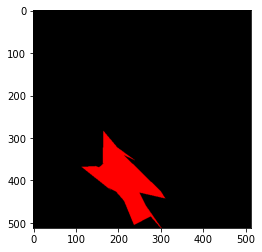

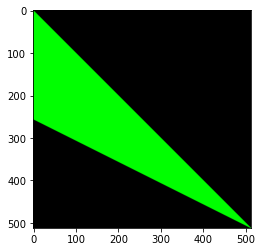

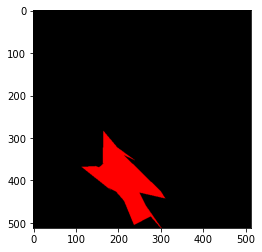

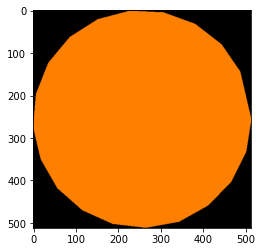

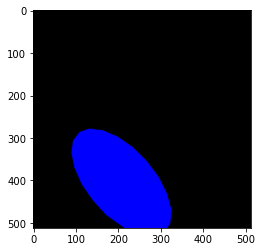

<Figure size 432x288 with 0 Axes>

In [6]:
from math import sin, cos
def draw_and_show_poly(poly, scale=32):
    im=Image.new('RGB', (scale,scale))
    dc = ImageDraw.Draw(im)
    draw_poly(dc,poly,scale=scale,fill="white")
    plt.figure()
    plt.imshow(im)
def create_transform_random():
    mat=np.random.uniform(0,1,(3,3))*0.5
    mat[2,0]=0
    mat[2,1]=0
    mat[2,2]=1
    return mat

def create_transform_identity():
    return np.eye(3,3)

def create_transform_informed(scale=(1.0,1.0), rotation=(0.0,0.0), symmetry=False, transform=(0.0,0.0), heat=0):
    res=np.eye(3)
    scaleness=np.eye(3)*np.random.uniform(*scale)
    res=res.dot(scaleness)
    rotateness=np.random.uniform(*rotation)
    if symmetry:
        rotateness += np.random.choice([0,.25,.5,.75])
    rotatarr=np.array([[ cos(rotateness*6.28), sin(rotateness*6.28), 0],
                         [-sin(rotateness*6.28), cos(rotateness*6.28), 0],
                         [0,0,1]])
    res=res.dot(rotatarr)
    hotness=create_transform_random()*heat
    res=res+(hotness-heat/2)
    res[0,2]=np.random.uniform(*transform)
    res[1,2]=np.random.uniform(*transform)
    return res
    
def transform(tform, points):
    res = np.concatenate([points,np.ones([points.shape[0],1])], axis=1)
    return res.dot(tform.transpose())[:,:2]

def render(dc,scale,tforms, shapes,colors):
    for t,sh,c in zip(tforms, shapes,colors):
        draw_poly(dc,transform(t,sh),scale=scale, fill=c)
        
def render_image(scale,tforms,shapes,colors):
    im = Image.new('RGB', (scale,scale))
    dc = ImageDraw.Draw(im)
    render(dc,scale,tforms,shapes,colors)
    return im
        
def create_random_icon(shapes, colors):
    structure = [create_transform_identity(),
                create_transform_informed(scale=(0.5,1.2), rotation=(0.0,1.0), symmetry=False, heat=0.2),
                create_transform_informed(scale=(0.5,1.2), rotation=(0.0,1.0), symmetry=False, heat=0.2),]
    colors = [tuple(colors[np.random.choice(len(colors))]),
              tuple(colors[np.random.choice(len(colors))]),
              tuple(colors[np.random.choice(len(colors))])]
    s = [shapes[np.random.choice(len(shapes))],
         shapes[np.random.choice(len(shapes))],
         shapes[np.random.choice(len(shapes))]]
    return structure,colors,s


def make_icon3(shapes, colors):
    im = Image.new('RGB', (32,32))
    dc = ImageDraw.Draw(im)
    shape1 = shapes[np.random.choice(len(shapes))]
    shape2 = shapes[np.random.choice(len(shapes))]
    tform=create_transform_identity()
    shape2=transform(tform,shape2)
    draw_poly(dc,shape2,scale=32,fill=tuple(colors[np.random.choice(len(colors))]))
    return im

def make_icon(shapes, colors):
    im = Image.new('RGB', (32,32))
    dc = ImageDraw.Draw(im)
    shape1 = shapes[np.random.choice(len(shapes))]
    shape2 = shapes[np.random.choice(len(shapes))]
    tform=create_transform_informed(scale=(0.5,1.2), rotation=(0.0,1.0), symmetry=False, heat=0.2)
    shape2=transform(tform,shape2)
    shape3 = shapes[np.random.choice(len(shapes))]
    tform=create_transform_informed(scale=(0.5,1.2), rotation=(0.0,1.0), symmetry=False, heat=0.2)
    shape3=transform(tform,shape3)
    draw_poly(dc,shape1,scale=32,fill=tuple(colors[np.random.choice(len(colors))]))
    draw_poly(dc,shape2,scale=32,fill=tuple(colors[np.random.choice(len(colors))]))
    draw_poly(dc,shape3,scale=32,fill=tuple(colors[np.random.choice(len(colors))]))
    return im

def make_icon2(scale,shapes, colors):
    structure,colors,s=create_random_icon(shapes,colors)
    return render_image(scale,structure,s,colors)
for i in range(5):
    plt.imshow(make_icon2(512,polys,colors))
    plt.figure()

In [7]:
synthetic_image_data = [create_random_icon(polys,colors) for _ in range(1000)]
len(synthetic_image_data)

1000

In [8]:
low_res_renders = [render_image(32,i[0],i[2],i[1]) for i in synthetic_image_data]
high_res_renders = [render_image(512,i[0],i[2],i[1]) for i in synthetic_image_data]

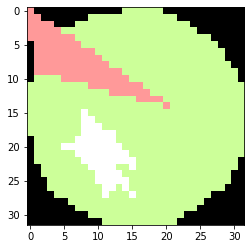

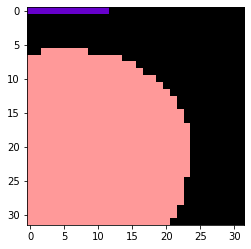

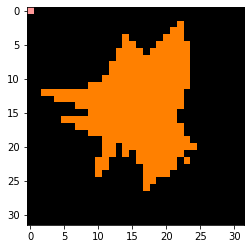

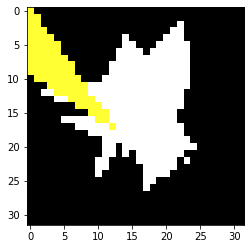

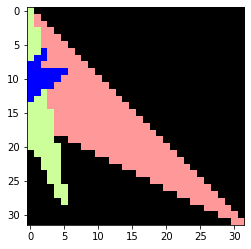

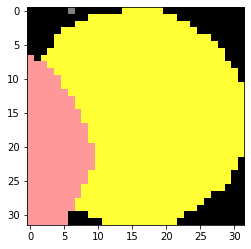

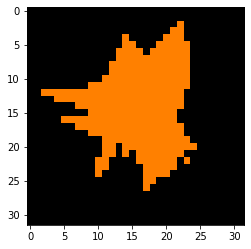

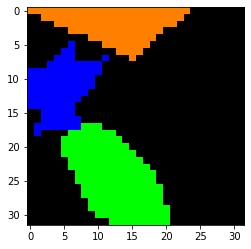

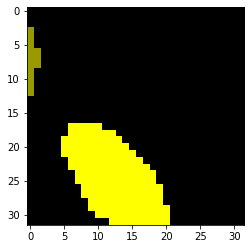

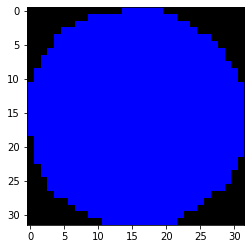

<Figure size 432x288 with 0 Axes>

In [14]:
for i in low_res_renders[:10]:
    plt.imshow(i)
    plt.figure()

In [26]:
# experiment config
exp_config = {
    'images':test_images
    'methods':[]
}

NameError: name 'tmp' is not defined

NameError: name 'mat' is not defined

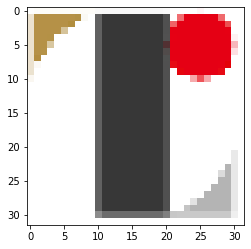

In [28]:
plt.imshow(test_images[-3])

In [30]:
cimg=test_images[-3].copy()

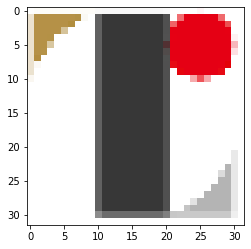

In [31]:
plt.imshow(cimg)

In [ ]:
def provenance(img):
    res=dict()
    for i in img:
        for j in i:
            res.setdefault(tuple(j), [0])[0] += 1
    return {r:res[r][0] for r in res}
def sort_colors(provs):
    psort = [p for p in provs]
    psort.sort(key=lambda k: provs[k],reverse=True)
    psort={p:provs[p] for p in psort}
    return psort
def pick_colors(psort, ts=0.1):
    tot=0
    res=[]
    for p in psort:
        if psort[p] > ts*tot:
            res.append(p)
            tot+=psort[p]
        else:
            break
    return res
def pick_n_colors(psort, n=1):
    res=[]
    colorseq=[k for k in psort.keys()]
    while n > 1 and len(res) < len(colorseq):
        res.append(colorseq[len(res)])
        n-=1
    if len(res) < len(colorseq) and n > 0:
        multis=np.expand_dims(np.array([psort[colorseq[i]] for i in range(len(res), len(colorseq))]), 1)
        aval=np.array([colorseq[i] for i in range(len(res), len(colorseq))])
        #print(aval)
        vals = aval*multis
        ncol = np.sum(vals,axis=0)/np.sum(multis)
        res.append(tuple(ncol.astype(int).tolist()))
        print(res[-1])
    return res
def assign_colors(colors, img):
    colors=np.array(colors)
    ds = np.expand_dims(img,2)-colors
    ds = abs(ds)
    ds = np.sum(ds,axis=-1)
    return colors[np.argmin(ds,axis=2)]

def assign_colors2(colors, img):
    colors=np.array(colors)
    mcolor=np.mean(colors,axis=0)
    cdirs=colors-mcolor
    print("as2",mcolor)
    ds = img-mcolor
    print(ds.shape)
    ds=ds.dot(cdirs.transpose())
    print('ayy lmao',ds.shape)
    #print('wtf', np.argmin(ds,axis=2))
    return colors[np.argmax(ds,axis=2)]

def flatten_colors(img):
    pimg=provenance(cimg)
    #print(pimg)
    psort = sort_colors(pimg)
    return assign_colors(pick_n_colors(psort,10),img)
#print(psort)
plt.imshow(flatten_colors(cimg))
#plt.imshow(assign_colors2(pick_n_colors(psort,6),cimg))

In [ ]:
psort

In [ ]:


print(pick_colors(psort,0.01))
print(pick_n_colors(psort, 4))
plt.imshow()

In [ ]:
np.zeros(cimg.shape[:-1]).shape[0]

In [ ]:
np.mean(c,axis=0)

In [ ]:
smooth_median(flatten_colors(cimg))

In [ ]:
def upscale(img,d=(128,128)):
    return cv2.resize(img,d,interpolation=cv2.INTER_NEAREST)
ufimg=upscale(flatten_colors(cimg))
plt.imshow(ufimg)
plt.figure()
print(flatten_colors(cimg).dtype)
print(cimg.shape)
print(ufimg.shape)
plt.imshow(cv2.medianBlur(flatten_colors(cimg).astype('uint8'),3))


In [ ]:

from PIL import ImageOps
#print(cimg)
# Try this this week, see if it works better than median filtering
pilimg=Image.fromarray(cimg)
plt.imshow(pilimg)
plt.figure()
aiimg = ImageOps.fit(pilimg, np.array(cimg.shape[:-1])*4, Image.ANTIALIAS)
plt.imshow(aiimg)
plt.figure()
plt.imshow(flatten_colors(aiimg))
plt.figure()
plt.imshow(cv2.medianBlur(np.array(aiimg),3))

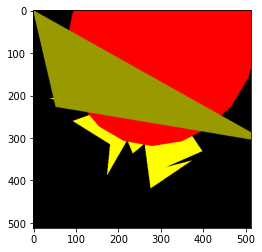

In [53]:
cimg=high_res_renders[105]
cimg=np.array(cimg)
plt.imshow(cimg)

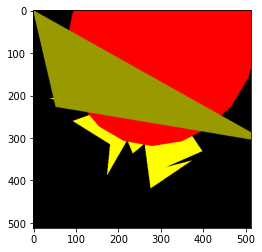

In [60]:
plt.imshow(cimg)

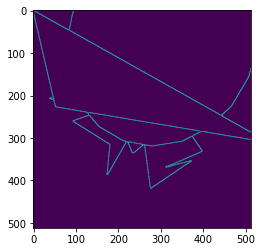

In [96]:
from imageprocessing import image_preprocess
gimg=cv2.cvtColor(cimg, cv2.COLOR_BGR2GRAY)
bimg=cv2.blur(gimg,(3,3))
#_,_,_,_,_,_,pimg = image_preprocess(bimg)
plt.imshow(pimg)

In [89]:
ret, thresh = cv2.threshold(pimg,127,255,0)
contours,h = cv2.findContours(bimg,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

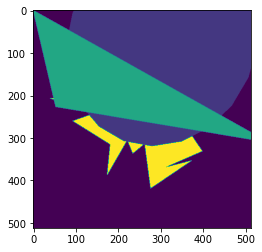

<Figure size 432x288 with 0 Axes>

In [97]:
gimg=cv2.cvtColor(cimg, cv2.COLOR_BGR2GRAY)
plt.imshow(gimg)
plt.figure()
#ret, thresh = cv2.threshold(gimg,127,255,0)
contours,h = cv2.findContours(bimg,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#plt.imshow(thresh)

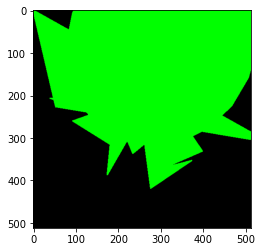

In [106]:
dimg=cimg.copy()
dimg=np.zeros(dimg.shape)
#cv2.drawContours(dimg, contours, 5, (0,255,0),3)
cv2.drawContours(dimg, contours, -1, (0,1,0), -1)
#cv2.fillPoly(dimg,pts=contours[5],color=1)
#cv2.fillPoly(dimg,pts=contours[5][:500],color=1)
plt.imshow(dimg)

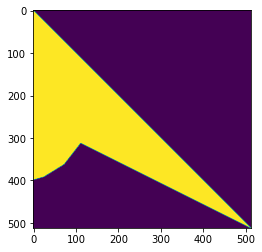

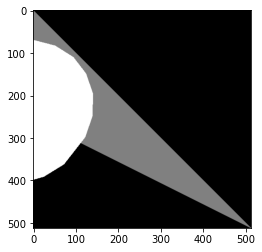

<Figure size 432x288 with 0 Axes>

In [46]:
def split_contour(img,center=True):
    # pass this an image, and it will return a list of sub-images.
    # method: determines whether to split by color or using the contour method
    # center: whether to center and resize the split parts, or to leave them in their original location in the image
    # hulls: if true use the convex hull of the contour, otherwise use the raw contour 
    masks=[]
    bgcolor=[0,0,0]
    gimg=maybetogray(img)
    ret, thresh = cv2.threshold(gimg,127,255,0)
    plt.imshow(thresh)
    plt.figure()
    contours,h=cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for i in range(len(contours)):
        masks += [cv2.drawContours(np.zeros_like(pimg), [cv2.convexHull(i) for i in contours], i, 1, -1)]
    if center:
        return [cropresize(img,b,bgcolor) for b in masks]
    else:
        return [maskout(img,b,bgcolor) for b in masks]    
splits=split_contour(cimg)
for s in splits:
    plt.imshow(s)
    plt.figure()

In [ ]:
cv2.FILLED

In [ ]:
cnt=np.array([[50,50],[50,150],[150,150],[150,50]])
image=np.zeros((200,200))

In [ ]:
cv2.fillPoly(image,pts=cnt,color=(255,255,255))
cv2.imshow("ggg",image)

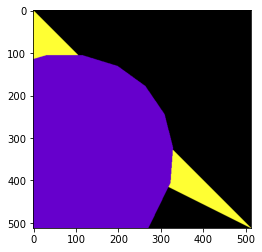

In [153]:
plt.imshow(high_res_renders[4])
timg3=np.array(high_res_renders[4])

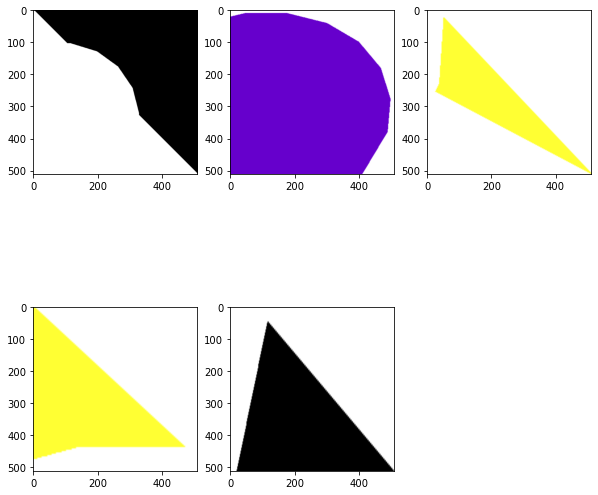

In [154]:
segimgs=segment_agglomerative(timg3,bg=[255,255,255])
plot_many(segimgs)

In [155]:
hdf5_file = h5py.File('LLD-icon.hdf5', 'r')
images, _ = (hdf5_file['data'], hdf5_file['labels/resnet/rc_64'])
# transpose the images because they're stored in a weird color channel first format, as indicated by shape[0] being 3
images = [np.transpose(i) if i.shape[0] == 3 else i for i in images[:100]]
print(len(images))


100


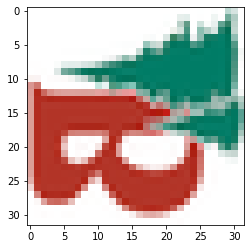

In [216]:
plt.imshow(images[66])

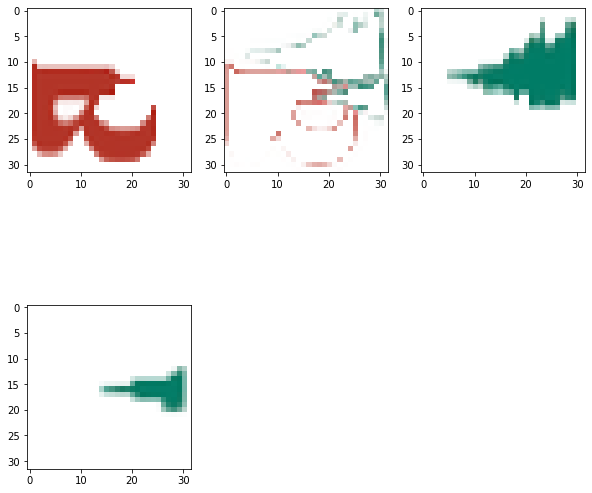

In [217]:
segimgs=segment_agglomerative(images[66],bg=[255,255,255],n_clusters=4)
plot_many(segimgs)

###### 